In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings
import pickle

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/test.csv', index_col='id')

In [4]:
feats_to_drop = [
    '_sort_6', '_cnt17', 'Deforestation', 'Watersheds', '_std', '_cnt1', '_cnt12', 
    '_cnt16', '_cnt8', '_sort_9', 'RiverManagement', 'Encroachments', '_30th', '_10th', 
    '_min', 'DrainageSystems', '_sort_7', '_40th', '_sort_5', 'PoliticalFactors', 
    'ClimateChange', '_mode', 'Landslides', 'TopographyDrainage', 'PopulationScore'
]
train = train.drop(columns=feats_to_drop)
test = test.drop(columns=feats_to_drop)

In [5]:
train.shape, test.shape

((1117957, 65), (745305, 64))

In [6]:
target_col = 'FloodProbability'

X = train.drop(target_col, axis=1)
y = train[target_col]

# Training

In [7]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 9,
    'n_estimators': 500,
    'random_state': SEED,
    'min_child_weight': 8,
    'alpha': 0.041033310817266855,
    'gamma': 9.882514950163898e-05,
    'subsample': 0.5750631450322976,
    'learning_rate': 0.012537590136013584,
    'colsample_bytree': 0.6811899771307238,
}

cb_params = {
    "depth": 12,
    "verbose": False,
    "num_leaves": 50,
    "thread_count": -1,
    "iterations": 1293,
    "border_count": 250,
    "random_state": SEED,
    "loss_function": "RMSE",
    "bootstrap_type": "MVS",
    "min_child_samples": 22,
    "grow_policy": "Lossguide",
    "l2_leaf_reg": 3.9480004489813214,
    "random_strength": 0.5931164016855051,
    "colsample_bylevel": 0.5635815011245612,
}

lgbm_params = {
    'n_jobs': -1,
    'max_depth': 10,
    'verbosity': -1,
    'num_leaves': 210,
    'n_estimators': 358,
    'random_state': SEED,
    'min_child_samples': 107,
    'subsample_for_bin': 260793,
    'subsample': 0.9511292897703636,
    'reg_alpha': 0.0007568231184782905,
    'reg_lambda': 1.537855810715304e-09,
    'learning_rate': 0.021723383535292705,
    'colsample_bytree': 0.815257637895832,
}

hgb_params = {
    'verbose': 0,
    'max_depth': 9,
    'max_bins': 245,
    'max_iter': 878,
    'warm_start': False,
    'random_state': SEED,
    'max_leaf_nodes': 141,
    'min_samples_leaf': 50,
    'loss': "squared_error",
    'l2_regularization': 0.479603063251666,
}

gb_params = {
    "max_depth": 9,
    "n_estimators": 369,
    'random_state': SEED,
    "alpha": 0.878238743008556,
    "subsample": 0.8110202065754267,
    "max_features": 0.3357955633913219,
    "learning_rate": 0.015631610015319746,
}

xgbrf_params = {
    "n_jobs": -1,
    "verbosity": 0,
    "max_depth": 12,
    "random_state": SEED
}

In [9]:
def train_regressor(regressor):
    trainer = Trainer(regressor, X, y)
    scores, oof_preds = trainer.fit()
    
    oof_preds_filename = f"{regressor.__class__.__name__.lower()}_oof_preds.pkl"
    with open(oof_preds_filename, 'wb') as f:
        pickle.dump(oof_preds, f)
    
    test_preds = trainer.predict(test)  
    test_preds_filename = f"{regressor.__class__.__name__.lower()}_test_preds.pkl"
    with open(test_preds_filename, 'wb') as f:
        pickle.dump(test_preds, f)
    
    print(f'{regressor.__class__.__name__}: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
    return scores, oof_preds, test_preds

xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds, xgb_test_preds = train_regressor(xgb_model)

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds, cb_test_preds = train_regressor(cb_model)

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds, lgbm_test_preds = train_regressor(lgbm_model)

hgb_model = HistGradientBoostingRegressor(**hgb_params)
hgb_scores, hgb_oof_preds, hgb_test_preds = train_regressor(hgb_model)

gb_model = GradientBoostingRegressor(**gb_params)
gb_scores, gb_oof_preds, gb_test_preds = train_regressor(gb_model)

xgbrf_model = XGBRFRegressor(**xgbrf_params)
xgbrf_scores, xgbrf_oof_preds, xgbrf_test_preds = train_regressor(xgbrf_model)

XGBRegressor: 0.869350 ± 0.000382
CatBoostRegressor: 0.869227 ± 0.000379
LGBMRegressor: 0.869334 ± 0.000374
HistGradientBoostingRegressor: 0.869254 ± 0.000386
GradientBoostingRegressor: 0.869295 ± 0.000384
XGBRFRegressor: 0.868982 ± 0.000375


In [10]:
_x = np.column_stack([
    xgb_oof_preds,
    cb_oof_preds, 
    lgbm_oof_preds,
    hgb_oof_preds, 
    gb_oof_preds,
    xgbrf_oof_preds
])

scaler = StandardScaler()
_x = pd.DataFrame(scaler.fit_transform(_x))

In [11]:
ridge = Ridge(positive=True, tol=1e-6).fit(_x, y)
ridge_preds = ridge.predict(_x)
ridge_score = r2_score(y, ridge_preds)
print(f'{ridge.__class__.__name__}: {ridge_score:.6f}')

ridge_cv = RidgeCV().fit(_x, y)
ridge_cv_preds = ridge_cv.predict(_x)
ridge_cv_score = r2_score(y, ridge_cv_preds)
print(f'{ridge_cv.__class__.__name__}: {ridge_cv_score:.6f} (alpha:{ridge_cv.alpha_})')

lasso = Lasso(alpha=1e-6).fit(_x, y)
lasso_preds = lasso.predict(_x)
lasso_score = r2_score(y, lasso_preds)
print(f'{lasso.__class__.__name__}: {lasso_score:.6f}')

lasso_cv = LassoCV().fit(_x, y)
lasso_cv_preds = lasso_cv.predict(_x)
lasso_cv_score = r2_score(y, lasso_cv_preds)
print(f'{lasso_cv.__class__.__name__}: {lasso_cv_score:.6f} (alpha:{lasso_cv.alpha_})')

Ridge: 0.869411
RidgeCV: 0.869411 (alpha:10.0)
Lasso: 0.869369
LassoCV: 0.869355 (alpha:4.757631615514536e-05)


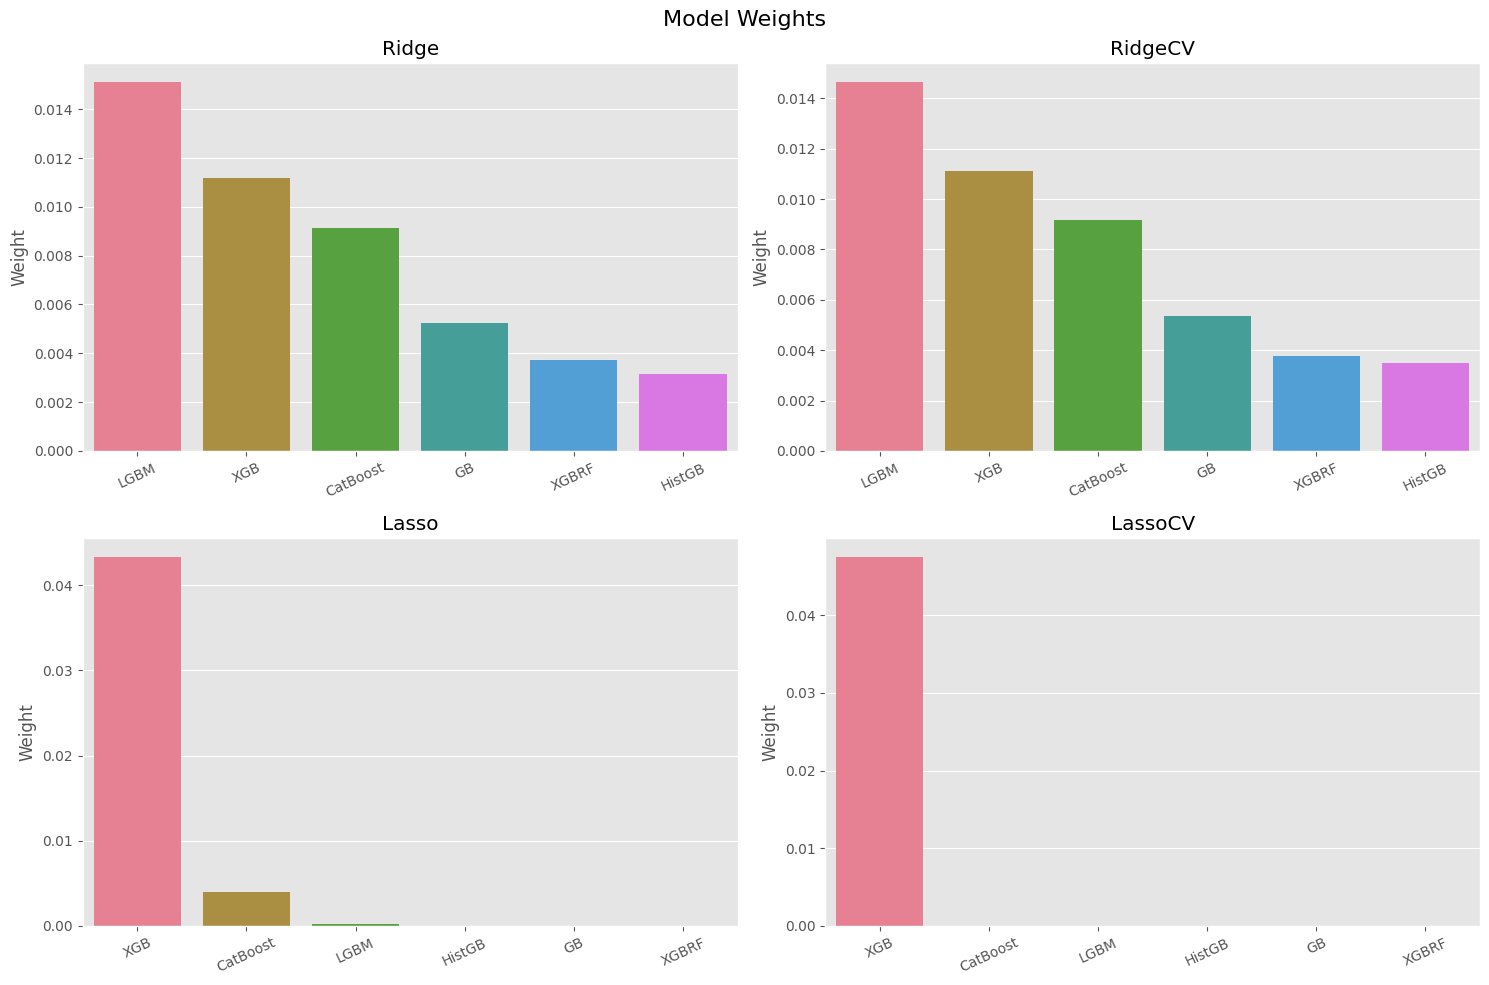

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models = [ridge, ridge_cv, lasso, lasso_cv]
model_names = [
    "XGB",
    "CatBoost",
    "LGBM", 
    "HistGB", 
    "GB",
    "XGBRF"
]

for ax, model in zip(axes.flatten(), models):
    weights = pd.Series(model.coef_, index=model_names).sort_values(ascending=False)
    sns.barplot(x=weights.index, y=weights.values, ax=ax, palette='husl')
    ax.set_title(f"{model.__class__.__name__}")
    ax.set_ylabel("Weight")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

fig.suptitle('Model Weights', fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
for model in [ridge, ridge_cv, lasso, lasso_cv]:
    weights = pd.Series(
        model.coef_, 
        index=[
            "XGBRegressor",
            "CatBoostRegressor",
            "LGBMRegressor", 
            "HistGradientBoostingRegressor", 
            "GradientBoostingRegressor",
            "XGBRFRegressor",
        ]
    )
    print(f"----------------- {model.__class__.__name__} -----------------")
    print(weights)
    print(f"\nSum: {np.sum(weights)}\n\n")

----------------- Ridge -----------------
XGBRegressor                     0.011192
CatBoostRegressor                0.009150
LGBMRegressor                    0.015124
HistGradientBoostingRegressor    0.003151
GradientBoostingRegressor        0.005257
XGBRFRegressor                   0.003707
dtype: float64

Sum: 0.047581326115304946


----------------- RidgeCV -----------------
XGBRegressor                     0.011125
CatBoostRegressor                0.009151
LGBMRegressor                    0.014658
HistGradientBoostingRegressor    0.003510
GradientBoostingRegressor        0.005373
XGBRFRegressor                   0.003764
dtype: float64

Sum: 0.0475812731156815


----------------- Lasso -----------------
XGBRegressor                     0.043335
CatBoostRegressor                0.004024
LGBMRegressor                    0.000221
HistGradientBoostingRegressor    0.000000
GradientBoostingRegressor       -0.000000
XGBRFRegressor                   0.000000
dtype: float64

Sum: 0.0475800

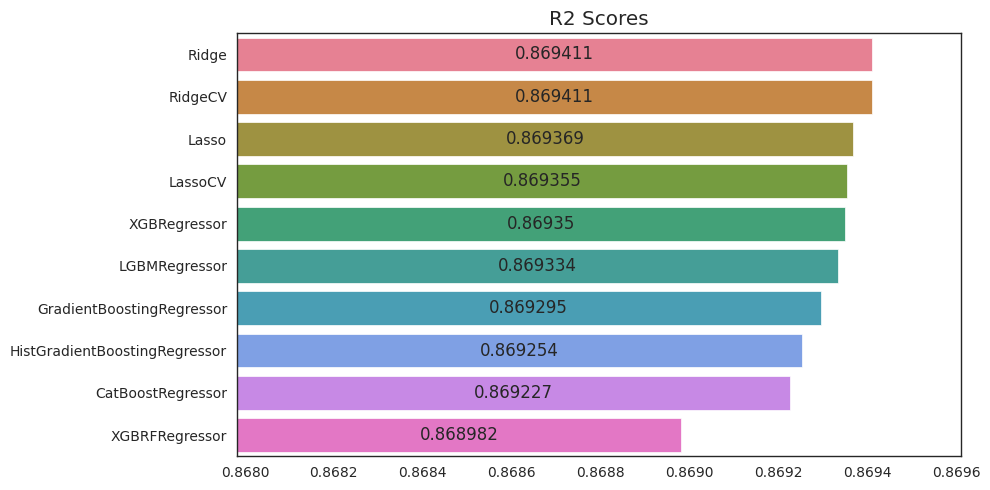

In [14]:
sns.set_style("white")
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    cb_model.__class__.__name__: cb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    hgb_model.__class__.__name__: hgb_scores,
    gb_model.__class__.__name__: gb_scores,
    xgbrf_model.__class__.__name__: xgbrf_scores,
    ridge.__class__.__name__: np.array([ridge_score] * 5),
    ridge_cv.__class__.__name__: np.array([ridge_cv_score] * 5),
    lasso.__class__.__name__: np.array([lasso_score] * 5),
    lasso_cv.__class__.__name__: np.array([lasso_cv_score] * 5)
})
scores = scores[scores.mean().sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')
ax.set_title('R2 Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.0002)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
model_preds = {
    xgb_model.__class__.__name__: xgb_oof_preds,
    cb_model.__class__.__name__: cb_oof_preds,
    lgbm_model.__class__.__name__: lgbm_oof_preds,
    hgb_model.__class__.__name__: hgb_oof_preds,
    gb_model.__class__.__name__: gb_oof_preds,
    xgbrf_model.__class__.__name__: xgbrf_oof_preds,
    ridge_cv.__class__.__name__: ridge_cv_preds
}

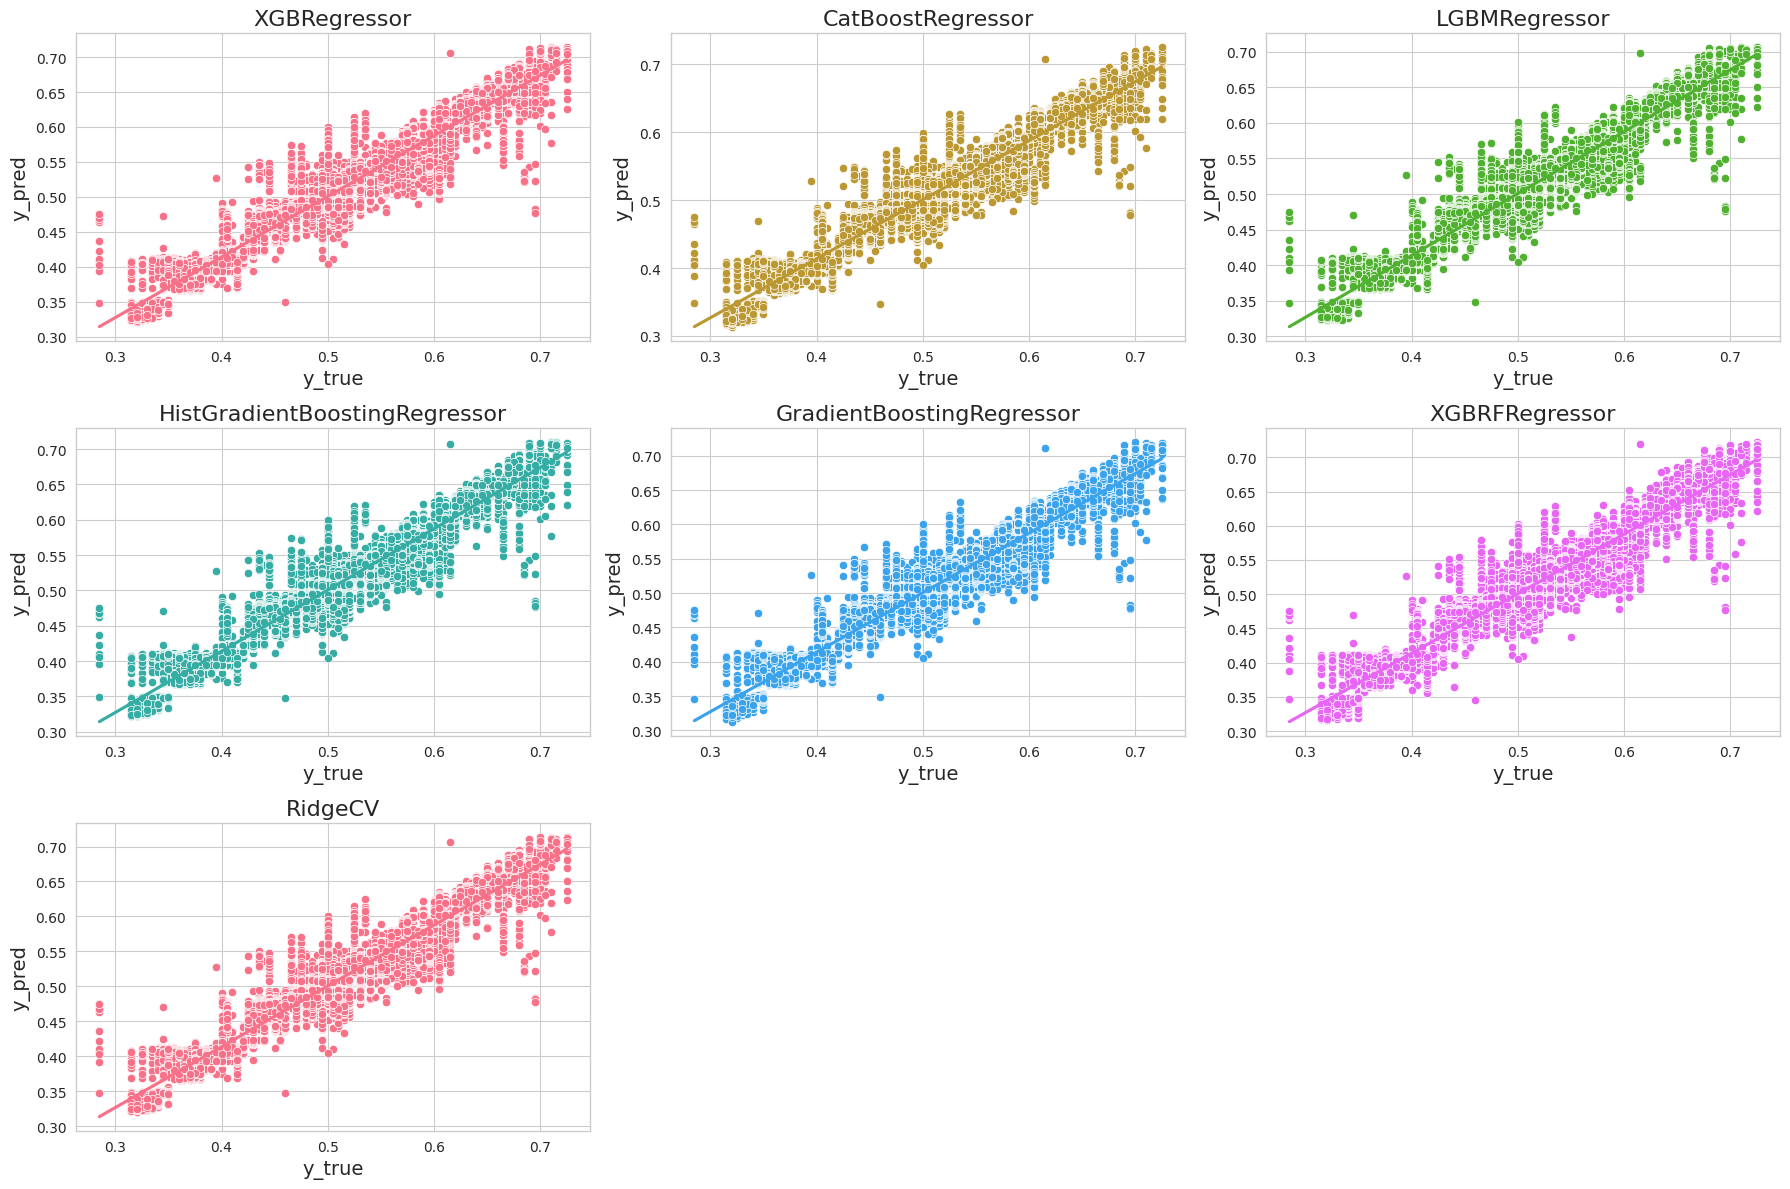

In [16]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    color = sns.color_palette("husl")[i % len(sns.color_palette("husl"))]
    
    sns.scatterplot(x=y, y=preds, ax=ax, color=color)
    sns.regplot(x=y, y=preds, ax=ax, scatter=False, color=color)
    
    ax.set_xlabel('y_true', fontsize=14)
    ax.set_ylabel('y_pred', fontsize=14)
    ax.set_title(model, fontsize=16)

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')
    
fig.delaxes(axes.flatten()[-2])

plt.tight_layout()
plt.show()

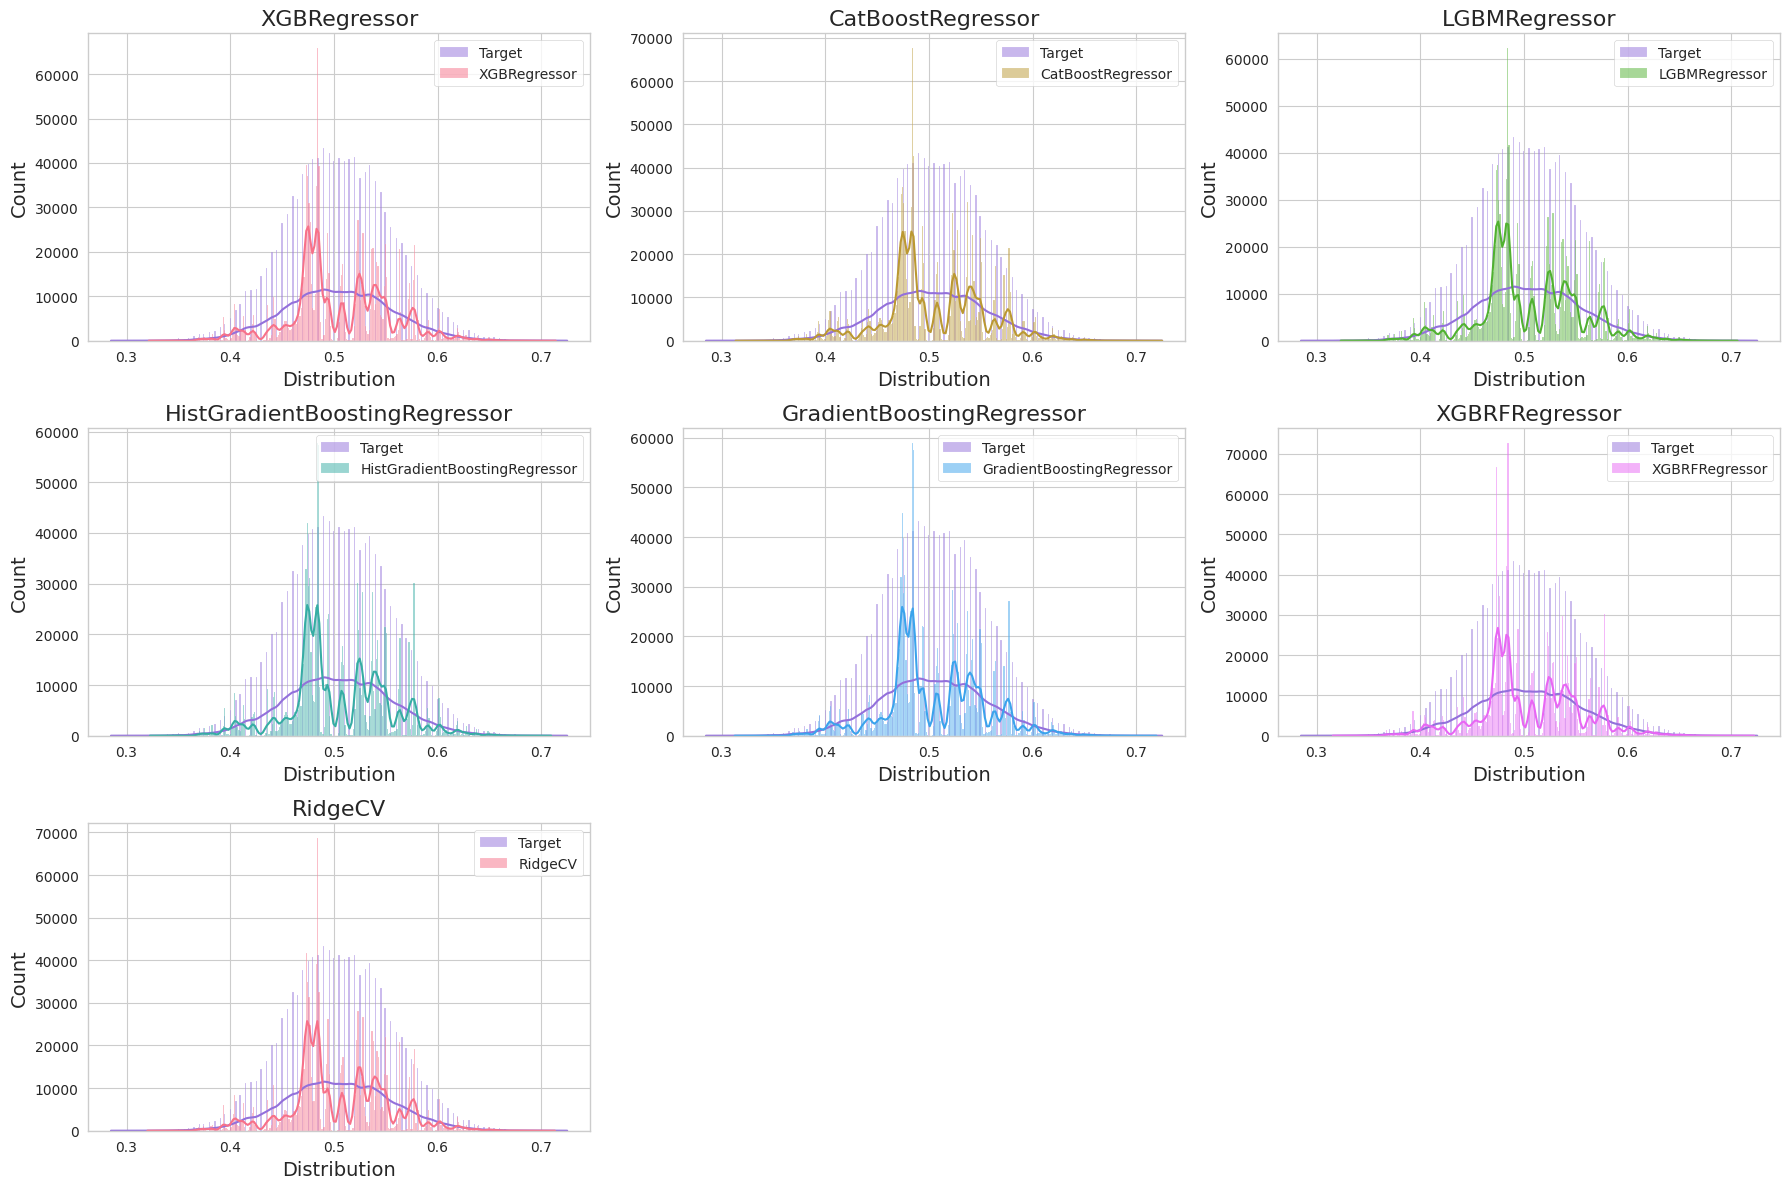

In [17]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    color = sns.color_palette("husl")[i % len(sns.color_palette("husl"))]
    
    sns.histplot(data=y, ax=ax, color='#9370DB', kde=True, legend=True, label="Target")
    sns.histplot(data=preds, ax=ax, color=color, kde=True, legend=True, label=model)
    
    ax.set_xlabel('Distribution', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(model, fontsize=16)
    ax.legend()

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')
    
fig.delaxes(axes.flatten()[-2])

plt.tight_layout()
plt.show()

# Making Predictions

In [18]:
ridge_x_test = np.column_stack([
    xgb_test_preds, 
    cb_test_preds,
    lgbm_test_preds, 
    hgb_test_preds, 
    gb_test_preds, 
    xgbrf_test_preds,
])
scaler = StandardScaler()
ridge_x_test = pd.DataFrame(scaler.fit_transform(ridge_x_test))

In [19]:
y_pred = ridge_cv.predict(ridge_x_test)
submission = pd.DataFrame({'id': test.index, target_col: y_pred})
submission.to_csv(f'ensemble.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.578408
1,1117958,0.456030
2,1117959,0.448978
3,1117960,0.466742
4,1117961,0.466261
